# RNN_LSTM Predictions

In [1074]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import confusion_matrix, classification_report

In [1075]:
y_df = pd.read_csv("yieldcurves_v2.csv", parse_dates=['Date'])

In [1076]:
sp_df = pd.read_csv("SPX_500_Data.csv",parse_dates=['Date'])

In [1077]:
y_df.set_index("Date", inplace = True)
sp_df.set_index("Date", inplace = True)

In [1078]:
y_df.shape

(8008, 10)

In [1079]:
y_df.head()

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,30 Yr,Recession
Date,,,,,,,,,,
1990-01-02,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,8.00,0
1990-01-03,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,8.04,0
1990-01-04,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,8.04,0
1990-01-05,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,8.06,0
1990-01-08,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,8.09,0


In [1080]:
y_df.tail()

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,30 Yr,Recession
Date,,,,,,,,,,
2021-12-27,0.06,0.21,0.33,0.76,0.98,1.26,1.41,1.48,1.88,0
2021-12-28,0.06,0.20,0.39,0.74,0.99,1.27,1.41,1.49,1.90,0
2021-12-29,0.05,0.19,0.38,0.75,0.99,1.29,1.47,1.55,1.96,0
2021-12-30,0.05,0.19,0.38,0.73,0.98,1.27,1.44,1.52,1.93,0
2021-12-31,0.06,0.19,0.39,0.73,0.97,1.26,1.44,1.52,1.90,0


In [1081]:
sp_df.tail()

,Open,High,Low,Close,Adj Close,Volume,% Gain/Loss (Close),% Price Variation
Date,,,,,,,,
2021-09-13,4474.81,4492.99,4445.70,4468.73,4468.73,3096390000,0.2271,0.011
2021-09-14,4479.33,4485.68,4435.46,4443.05,4443.05,2568730000,-0.5780,0.011
2021-09-15,4447.49,4486.87,4438.37,4480.70,4480.70,3154760000,0.8403,0.011
2021-09-16,4477.09,4485.87,4443.80,4473.75,4473.75,3321030000,-0.1554,0.009
2021-09-17,4469.74,4471.52,4427.76,4432.99,4432.99,5622210000,-0.9195,0.010


In [1082]:
sp_df.tail()

,Open,High,Low,Close,Adj Close,Volume,% Gain/Loss (Close),% Price Variation
Date,,,,,,,,
2021-09-13,4474.81,4492.99,4445.70,4468.73,4468.73,3096390000,0.2271,0.011
2021-09-14,4479.33,4485.68,4435.46,4443.05,4443.05,2568730000,-0.5780,0.011
2021-09-15,4447.49,4486.87,4438.37,4480.70,4480.70,3154760000,0.8403,0.011
2021-09-16,4477.09,4485.87,4443.80,4473.75,4473.75,3321030000,-0.1554,0.009
2021-09-17,4469.74,4471.52,4427.76,4432.99,4432.99,5622210000,-0.9195,0.010


In [1083]:
y_df.isnull().sum()

3 Mo            4
6 Mo            1
1 Yr            1
2 Yr            1
3 Yr            1
5 Yr            1
7 Yr            1
10 Yr           1
30 Yr         995
Recession       0
dtype: int64

In [1084]:
import datetime

def fill_nan_with_weekly_average(df):
  # Compute weekly averages

  monday = pd.Timestamp("1990-01-08")
  lastday = pd.Timestamp("2021-12-31")

  prev_avg = {}
  avg = {}
  while monday <= lastday:
    week = pd.date_range(monday, periods = 5, freq = "D")
    sub_df = df[week[0]:week[4]]

    for col in sub_df:
      avg[col] = sub_df[col].mean(skipna=True)
      if pd.isna(avg[col]):
        avg[col] = prev_avg[col]
      else:
        prev_avg[col] = avg[col]
      if sub_df[col].isnull().sum() != 0:
        for idx in week:
          try:
            if pd.isna(df[col].loc[idx]):
              df[col].loc[idx] = avg[col]
          except KeyError as e:
            # Must be a holiday
            pass
        
    monday = week[4] + datetime.timedelta(3
                                          )

fill_nan_with_weekly_average(y_df)

/var/folders/25/kxl7v5ls5mbflwc4p84qhy8m0000gn/T/ipykernel_6150/2442879773.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].loc[idx] = avg[col]


In [1085]:
y_df.isnull().sum()

3 Mo          0
6 Mo          0
1 Yr          0
2 Yr          0
3 Yr          0
5 Yr          0
7 Yr          0
10 Yr         0
30 Yr         0
Recession     0
dtype: int64

In [1086]:
y_df["diff"] = y_df["10 Yr"] - y_df["2 Yr"]

In [1087]:
y_df.head()

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,30 Yr,Recession,diff
Date,,,,,,,,,,,
1990-01-02,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,8.00,0,0.07
1990-01-03,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,8.04,0,0.05
1990-01-04,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,8.04,0,0.06
1990-01-05,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,8.06,0,0.09
1990-01-08,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,8.09,0,0.12


In [1088]:
df = pd.merge(y_df, sp_df, on = ["Date"])

In [1089]:
df.head()

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,30 Yr,Recession,diff,Open,High,Low,Close,Adj Close,Volume,% Gain/Loss (Close),% Price Variation
Date,,,,,,,,,,,,,,,,,,,
1990-01-02,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,8.00,0,0.07,353.40,359.69,351.98,359.69,359.69,162070000,1.7487,0.021
1990-01-03,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,8.04,0,0.05,359.69,360.59,357.89,358.76,358.76,192330000,-0.2592,0.008
1990-01-04,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,8.04,0,0.06,358.76,358.76,352.89,355.67,355.67,177000000,-0.8688,0.017
1990-01-05,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,8.06,0,0.09,355.67,355.67,351.35,352.20,352.20,158530000,-0.9852,0.012
1990-01-08,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,8.09,0,0.12,352.20,354.24,350.54,353.79,353.79,140110000,0.4494,0.010


In [1090]:
del df["Open"]

In [1091]:
df.head()

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,30 Yr,Recession,diff,High,Low,Close,Adj Close,Volume,% Gain/Loss (Close),% Price Variation
Date,,,,,,,,,,,,,,,,,,
1990-01-02,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,8.00,0,0.07,359.69,351.98,359.69,359.69,162070000,1.7487,0.021
1990-01-03,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,8.04,0,0.05,360.59,357.89,358.76,358.76,192330000,-0.2592,0.008
1990-01-04,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,8.04,0,0.06,358.76,352.89,355.67,355.67,177000000,-0.8688,0.017
1990-01-05,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,8.06,0,0.09,355.67,351.35,352.20,352.20,158530000,-0.9852,0.012
1990-01-08,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,8.09,0,0.12,354.24,350.54,353.79,353.79,140110000,0.4494,0.010


# Split Data

In [1092]:
y = df['Recession ']

X = df.drop(columns=['Recession '])

In [1093]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

In [1094]:
X_scaler = StandardScaler().fit(X_train)

In [1095]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_valid_scaled = X_scaler.transform(X)

In [1096]:
def reshape_data(x):
    obj = np.reshape(x, (x.shape[0], x.shape[1], 1))
    return obj

In [1097]:
reshaped_X1_train_scaled = reshape_data(X_train_scaled)
reshaped_X1_test_scaled = reshape_data(X_test_scaled)
reshaped_X1_valid = reshape_data(X_valid_scaled)

# Build Model

In [1098]:
model = Sequential()

In [1099]:
model.add(LSTM(128, input_shape=(reshaped_X1_train_scaled.shape[1],1), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [1100]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [1101]:
model.fit(reshaped_X1_train_scaled, y_train, validation_split=0.1, epochs=10, shuffle=True, verbose=2)

Epoch 1/10
179/179 - 10s - loss: 0.2588 - accuracy: 0.9045 - val_loss: 0.5407 - val_accuracy: 0.6577 - 10s/epoch - 53ms/step
Epoch 2/10
179/179 - 5s - loss: 0.1803 - accuracy: 0.9318 - val_loss: 0.8144 - val_accuracy: 0.5252 - 5s/epoch - 28ms/step
Epoch 3/10
179/179 - 5s - loss: 0.1359 - accuracy: 0.9469 - val_loss: 0.1047 - val_accuracy: 0.9621 - 5s/epoch - 28ms/step
Epoch 4/10
179/179 - 5s - loss: 0.1264 - accuracy: 0.9495 - val_loss: 0.0898 - val_accuracy: 0.9716 - 5s/epoch - 27ms/step
Epoch 5/10
179/179 - 5s - loss: 0.1183 - accuracy: 0.9539 - val_loss: 0.0803 - val_accuracy: 0.9669 - 5s/epoch - 28ms/step
Epoch 6/10
179/179 - 5s - loss: 0.1197 - accuracy: 0.9508 - val_loss: 0.3641 - val_accuracy: 0.8107 - 5s/epoch - 28ms/step
Epoch 7/10
179/179 - 5s - loss: 0.1080 - accuracy: 0.9548 - val_loss: 0.0949 - val_accuracy: 0.9621 - 5s/epoch - 28ms/step
Epoch 8/10
179/179 - 5s - loss: 0.1076 - accuracy: 0.9555 - val_loss: 0.0866 - val_accuracy: 0.9669 - 5s/epoch - 28ms/step
Epoch 9/10
179

In [1112]:
predictions1_class = model.predict(reshaped_X1_test_scaled)
classes = np.argmax(predictions1_class,axis=1)

50/50 [==============================] - 0s 9ms/step


In [1110]:
# Classify 2020 Recession
recession = pd.DataFrame({"Predicted":classes, "Actual":y_test})
recession = recession.sort_index(ascending=True)
recession[1500:1520] 

,Predicted,Actual
Date,,
2019-11-25,0,0
2019-11-26,0,0
2019-12-04,0,0
2019-12-05,0,0
2019-12-11,0,0
2019-12-12,0,0
2019-12-20,0,0
2019-12-31,0,0
2020-01-02,0,0


In [1117]:
recession.loc[recession["Actual"]==1].head(20)

,Predicted,Actual
Date,,
1990-07-03,0,1
1990-07-06,1,1
1990-07-12,1,1
1990-07-18,0,1
1990-07-20,0,1
1990-08-14,0,1
1990-08-17,1,1
1990-08-20,0,1
1990-08-30,1,1


In [1119]:
recession.tail(20)

,Predicted,Actual
Date,,
2021-05-19,0,0
2021-05-24,0,0
2021-06-07,0,0
2021-06-10,0,0
2021-06-11,0,0
2021-06-28,0,0
2021-06-30,0,0
2021-07-01,0,0
2021-07-02,0,0


# Predict on 2008

In [756]:
df_2008 = df[4500:5000]

In [757]:
del df_2008['Recession ']

In [758]:
from sklearn import *
scaled_X1_2008 = X_scaler.transform(df_2008)
reshaped_X1_2008 = reshape_data(scaled_X1_2008) 
pred_X1_2008 = model.predict(reshaped_X1_2008)
pred_classes = np.argmax(pred_X1_2008,axis=1)

16/16 [==============================] - 0s 10ms/step


In [766]:
recession = pd.DataFrame({"Predicted":pred_classes})
recession.head()

,Predicted
0,1
1,1
2,1
3,1
4,1


In [914]:
print(pred_X1_2008[1][1]) 
print(pred_X1_2008[1][0]) 
print(pred_X1_2008[0][1]) 
print(pred_X1_2008[0][0])

0.89541066
0.10458931
0.8729673
0.12703271


# Predict One Quarter Before 2008 Recession

In [927]:
df['one_q'] = df['Recession '].shift(-92)
df1 = df.drop(columns=['Recession '])
df1 = df1.fillna(0)
y1 = df1['one_q']
X1 = df1.drop(columns=['one_q'])

In [928]:
df1_feature_names = X1.columns

In [929]:
X1_train, X1_test, y1_train, y1_test=train_test_split(X1, y1, train_size=0.8, stratify=y1)

In [930]:
X1_scaler = StandardScaler().fit(X1_train)
X1_train_scaled = X1_scaler.transform(X1_train)
X1_test_scaled = X1_scaler.transform(X1_test)

In [931]:
X1_train.shape, X1_test.shape

((6340, 17), (1586, 17))

In [932]:
model = Sequential()

In [933]:
model.add(LSTM(128, input_shape=(X1_train_scaled.shape[1],1), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [934]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [935]:
model.fit(X1_train_scaled, y1_train, validation_split=0.1, epochs=10, shuffle=True, verbose=2)

Epoch 1/10
179/179 - 10s - loss: 0.3003 - accuracy: 0.8847 - val_loss: 0.4400 - val_accuracy: 0.8675 - 10s/epoch - 56ms/step
Epoch 2/10
179/179 - 5s - loss: 0.1675 - accuracy: 0.9387 - val_loss: 1.1215 - val_accuracy: 0.4038 - 5s/epoch - 28ms/step
Epoch 3/10
179/179 - 5s - loss: 0.1520 - accuracy: 0.9451 - val_loss: 0.2399 - val_accuracy: 0.8880 - 5s/epoch - 27ms/step
Epoch 4/10
179/179 - 5s - loss: 0.1294 - accuracy: 0.9518 - val_loss: 0.1297 - val_accuracy: 0.9543 - 5s/epoch - 27ms/step
Epoch 5/10
179/179 - 5s - loss: 0.1150 - accuracy: 0.9579 - val_loss: 0.1595 - val_accuracy: 0.9274 - 5s/epoch - 28ms/step
Epoch 6/10
179/179 - 5s - loss: 0.1073 - accuracy: 0.9581 - val_loss: 0.1107 - val_accuracy: 0.9543 - 5s/epoch - 30ms/step
Epoch 7/10
179/179 - 6s - loss: 0.0938 - accuracy: 0.9639 - val_loss: 0.1057 - val_accuracy: 0.9574 - 6s/epoch - 32ms/step
Epoch 8/10
179/179 - 5s - loss: 0.0926 - accuracy: 0.9657 - val_loss: 0.0665 - val_accuracy: 0.9685 - 5s/epoch - 30ms/step
Epoch 9/10
179

In [937]:
predictions1_class = model.predict(X1_test)
classes = np.argmax(predictions1_class,axis=1)

50/50 [==============================] - 1s 10ms/step


In [1048]:
recession_08 = pd.DataFrame({"Predicted":classes, "Actual":y1_test})
recession_08 = recession_08.sort_index(ascending=True)
recession_08.loc[recession_08["Predicted"]==1][750:780]

,Predicted,Actual
Date,,
2005-07-01,1,0.0
2005-07-15,1,0.0
2005-07-18,1,0.0
2005-07-20,1,0.0
2005-07-21,1,0.0
2005-07-25,1,0.0
2005-07-26,1,0.0
2005-07-29,1,0.0
2005-08-01,1,0.0


# Predict 2022 Recession One Quarter Before 

In [788]:
r22 = pd.read_csv("newyield.csv", parse_dates=['Date'])

In [789]:
r22.set_index("Date", inplace = True)

In [858]:
r22.tail()

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,30 Yr,Recession,diff,one_q
Date,,,,,,,,,,,,
2022-07-14,2.40,2.93,3.16,3.15,3.16,3.06,3.05,2.96,3.11,NaN,-0.19,NaN
2022-07-15,2.37,2.94,3.12,3.13,3.14,3.05,3.03,2.93,3.10,NaN,-0.20,NaN
2022-07-18,2.50,3.02,3.13,3.15,3.15,3.06,3.05,2.96,3.14,NaN,-0.19,NaN
2022-07-19,2.52,3.06,3.18,3.23,3.22,3.14,3.11,3.01,3.17,NaN,-0.22,NaN
2022-07-20,2.51,3.04,3.18,3.25,3.25,3.18,3.15,3.04,3.17,NaN,-0.21,NaN


In [791]:
fill_nan_with_weekly_average(r22)

In [792]:
r22.isna().any()

3 Mo          False
6 Mo          False
1 Yr          False
2 Yr          False
3 Yr          False
5 Yr          False
7 Yr          False
10 Yr         False
30 Yr         False
Recession      True
dtype: bool

In [793]:
r22.fillna(0)

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,30 Yr,Recession
Date,,,,,,,,,,
1990-01-02,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,8.00,0.0
1990-01-03,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,8.04,0.0
1990-01-04,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,8.04,0.0
1990-01-05,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,8.06,0.0
1990-01-08,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,8.09,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-07-14,2.40,2.93,3.16,3.15,3.16,3.06,3.05,2.96,3.11,0.0
2022-07-15,2.37,2.94,3.12,3.13,3.14,3.05,3.03,2.93,3.10,0.0
2022-07-18,2.50,3.02,3.13,3.15,3.15,3.06,3.05,2.96,3.14,0.0


In [982]:
r22["diff"] = r22["10 Yr"] - r22["2 Yr"]
r22.head()

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,30 Yr,Recession,diff,one_q
Date,,,,,,,,,,,,
1990-01-02,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,8.00,0.0,0.07,0.0
1990-01-03,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,8.04,0.0,0.05,0.0
1990-01-04,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,8.04,0.0,0.06,0.0
1990-01-05,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,8.06,0.0,0.09,0.0
1990-01-08,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,8.09,0.0,0.12,0.0


In [985]:
r22['Recession ']
r22 = r22.fillna(0)
r22.head()

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,30 Yr,Recession,diff,one_q
Date,,,,,,,,,,,,
1990-01-02,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,8.00,0.0,0.07,0.0
1990-01-03,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,8.04,0.0,0.05,0.0
1990-01-04,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,8.04,0.0,0.06,0.0
1990-01-05,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,8.06,0.0,0.09,0.0
1990-01-08,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,8.09,0.0,0.12,0.0


# Predict Using S&P 500 and Yield Curve 2022

In [1012]:
sp = pd.read_csv('HistoricalPrices.csv', parse_dates=['Date'])

In [1013]:
sp.set_index("Date", inplace = True)

In [1014]:
new = pd.merge(sp, r22, on=['Date'])

In [1015]:
new = new.sort_index(ascending=True)
new.tail()

,Open,High,Low,Close,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,30 Yr,Recession,diff,one_q
Date,,,,,,,,,,,,,,,,
2022-07-14,3763.99,3796.41,3721.56,3790.38,2.40,2.93,3.16,3.15,3.16,3.06,3.05,2.96,3.11,0.0,-0.19,0.0
2022-07-15,3818.00,3863.62,3817.18,3863.16,2.37,2.94,3.12,3.13,3.14,3.05,3.03,2.93,3.10,0.0,-0.20,0.0
2022-07-18,3883.79,3902.44,3818.63,3830.85,2.50,3.02,3.13,3.15,3.15,3.06,3.05,2.96,3.14,0.0,-0.19,0.0
2022-07-19,3860.73,3939.81,3860.73,3936.69,2.52,3.06,3.18,3.23,3.22,3.14,3.11,3.01,3.17,0.0,-0.22,0.0
2022-07-20,3935.32,3974.13,3922.03,3959.90,2.51,3.04,3.18,3.25,3.25,3.18,3.15,3.04,3.17,0.0,-0.21,0.0


In [1017]:
new = new.fillna(0)

In [1018]:
new.shape

(8134, 16)

In [1019]:
del new['one_q']

In [1020]:
new.head()

,Open,High,Low,Close,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,30 Yr,Recession,diff
Date,,,,,,,,,,,,,,,
1990-01-02,359.69,359.69,351.98,359.69,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,8.00,0.0,0.07
1990-01-03,358.76,360.59,357.89,358.76,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,8.04,0.0,0.05
1990-01-04,355.67,358.76,352.89,355.67,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,8.04,0.0,0.06
1990-01-05,352.20,355.67,351.35,352.20,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,8.06,0.0,0.09
1990-01-08,353.79,354.24,350.54,353.79,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,8.09,0.0,0.12


In [1021]:
new['one_q'] = new['Recession '].shift(-92)
df1 = new.drop(columns=['Recession '])
df1 = df1.fillna(0)
y1 = df1['one_q']
X1 = df1.drop(columns=['one_q'])

In [1022]:
df1_feature_names = X1.columns

In [1023]:
X1_train, X1_test, y1_train, y1_test=train_test_split(X1, y1, train_size=0.8, stratify=y1)

In [1024]:
X1_scaler = StandardScaler().fit(X1_train)
X1_train_scaled = X1_scaler.transform(X1_train)
X1_test_scaled = X1_scaler.transform(X1_test)

In [1025]:
X1_train.shape, X1_test.shape

((6507, 14), (1627, 14))

In [1026]:
model=Sequential()
model.add(LSTM(128, input_shape=(X1_train_scaled.shape[1],1), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [1027]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [1028]:
model.fit(X1_train_scaled, y1_train, validation_split=0.1, epochs=10, shuffle=True, verbose=2)

Epoch 1/10
183/183 - 8s - loss: 0.3153 - accuracy: 0.8700 - val_loss: 0.9086 - val_accuracy: 0.4409 - 8s/epoch - 46ms/step
Epoch 2/10
183/183 - 4s - loss: 0.1804 - accuracy: 0.9361 - val_loss: 1.0148 - val_accuracy: 0.4808 - 4s/epoch - 21ms/step
Epoch 3/10
183/183 - 4s - loss: 0.1559 - accuracy: 0.9440 - val_loss: 0.2367 - val_accuracy: 0.9293 - 4s/epoch - 22ms/step
Epoch 4/10
183/183 - 4s - loss: 0.1375 - accuracy: 0.9477 - val_loss: 0.0934 - val_accuracy: 0.9631 - 4s/epoch - 23ms/step
Epoch 5/10
183/183 - 4s - loss: 0.1306 - accuracy: 0.9513 - val_loss: 0.1269 - val_accuracy: 0.9508 - 4s/epoch - 23ms/step
Epoch 6/10
183/183 - 4s - loss: 0.1173 - accuracy: 0.9549 - val_loss: 0.0752 - val_accuracy: 0.9739 - 4s/epoch - 23ms/step
Epoch 7/10
183/183 - 4s - loss: 0.1049 - accuracy: 0.9549 - val_loss: 0.1111 - val_accuracy: 0.9478 - 4s/epoch - 24ms/step
Epoch 8/10
183/183 - 5s - loss: 0.0920 - accuracy: 0.9636 - val_loss: 0.0669 - val_accuracy: 0.9724 - 5s/epoch - 25ms/step
Epoch 9/10
183/1

In [1029]:
predictions_class = model.predict(X1_test)
classes = np.argmax(predictions_class,axis=1)

51/51 [==============================] - 1s 9ms/step


In [1041]:
recession_2022 = pd.DataFrame({"2022 Prediction":classes, "Actual":y1_test})
recession_2022 = recession_2022.sort_index(ascending=True)
recession_2022.loc[recession_2022["2022 Prediction"]==1].tail(10)

,2022 Prediction,Actual
Date,,
2022-05-02,1,0.0
2022-05-13,1,0.0
2022-05-16,1,0.0
2022-05-18,1,0.0
2022-06-08,1,0.0
2022-06-13,1,0.0
2022-06-14,1,0.0
2022-07-01,1,0.0
2022-07-12,1,0.0


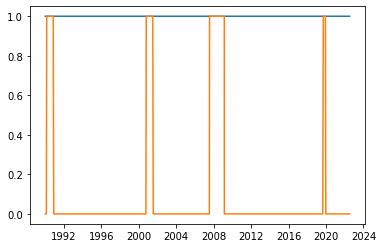

In [1046]:
plt.plot(recession_2022) 